# Objective: Classify Yelp photo data into five categories using Inception V3 in Keras

In [1]:
''' Classify Yelp photo data into five categories using Inception V3 in Keras developed by Priyanka Singhal
    credits: https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
    https://github.com/autonomio/talos
'''
# import libraries
# Install modules
# !pip install tensorflow
# !pip install -q keras
# !pip install wrapt
# !pip install talos 

import tensorflow as tf
import pandas as pd
import os
import posix
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


## Prerequisites -
### Ensure that you download the yelp photo dataset locally using this link: 
    https://www.yelp.com/dataset/download
### Please proceed to the next step only once you have the folder structure like this:
    > yelp_photos
        > photo.json
        > photos 
### Total number of images should be 200000

In [2]:
# Set working directory default path <to be changed based on local dir path>
dir_path = "/home/aman2304/Desktop/pinks/yelp_project/yelp_photos"
os.chdir(dir_path)

# Set test and Training directory folder
TRAIN_DIR = 'photos/train'
TEST_DIR = 'photos/test'

# Step 1: Data Preprocessing and Analysis - Data Preprocessing part 1/2

## Step 1.1: Load the yelp image dataset

In [3]:
yelp_photo_df = pd.read_json ('photo.json', lines=True)
yelp_photo_df.head(3)

,business_id,caption,label,photo_id
0,rcaPajgKOJC2vo_l3xa42A,,inside,MllA1nNpcp1kDteVg6OGUw
1,Kn23LDd740SBVJ7mum0fwg,,inside,YjxBE88Bf6CmTEF2LP1UNA
2,ZkGDCVKSdf8m76cnnalL-A,,food,1f7izSjM0WjkDRIVbPy1yw


In [4]:
# Print the categories/labels for the photo classifier
yelp_photo_df.label.unique()

array([u'inside', u'food', u'outside', u'drink', u'menu'], dtype=object)

## Step 1.2: Train data preparation
    Step 1.2.1: Create empty folder structure like this : 
        train 
            > inside 
            > food
            > outside
            > drink
            > menu
    Step 1.2.2: Categorize images into different folders under train directory for eg: inside, outside, menu, food, drink
    Step 1.2.3: Print the count of files in each folder

In [5]:
# Move inside photos to inside folder
import shutil

def data_preparation_folder_creation(methodtype):  
    if methodtype == 'test':
        source_dir = TEST_DIR
    else:
        source_dir = TRAIN_DIR
        
    if not os.path.isdir(source_dir):
        path = os.path.join(source_dir) 
#         os.mkdir(path, mode=0o777) 
        if not os.path.isdir(source_dir+"/inside"): 
            path = source_dir+ "/inside"
#             os.mkdir(path, mode=0o777) 
        if not os.path.isdir(source_dir+"/outside"): 
            path = source_dir+ "/outside"
#             os.mkdir(path, mode=0o777) 
        if not os.path.isdir(source_dir+"/drink"): 
            path = source_dir+"/drink"
#             os.mkdir(path, mode=0o777) 
        if not os.path.isdir(source_dir+"/food"): 
            path = source_dir+"/food"
#             os.mkdir(path, mode=0o777) 
        if not os.path.isdir(source_dir+"/menu"):
            path = source_dir+ "/menu"
#             os.mkdir(path, mode=0o777) 

        os.listdir(source_dir)

def categorize_images_into_train_folder(image_from_dir, image_to_dir):
    # Utility to copy images into respective folders

    for index, row in yelp_photo_df.iterrows():
        source_image_path = image_from_dir+'/'+row['photo_id']+'.jpg'
        if row['label'] == 'inside':
                shutil.copyfile( source_image_path, image_to_dir+'/inside/'+row['photo_id']+'.jpg')
        elif row['label'] == 'outside':  
                shutil.copyfile(source_image_path, image_to_dir+'/outside/'+row['photo_id']+'.jpg')
        elif row['label'] == 'food':
                shutil.copyfile(source_image_path, image_to_dir+'/food/'+row['photo_id']+'.jpg')
        elif row['label'] == 'drink':
                shutil.copyfile(source_image_path, image_to_dir+'/drink/'+row['photo_id']+'.jpg')
        elif row['label'] == 'menu':
                shutil.copyfile(source_image_path, image_to_dir+'/menu/'+row['photo_id']+'.jpg')
        else:
            print("na")

            
def print_count_of_files():
    print('photos/train/inside')
    !ls photos/train/inside | wc -l
    print('photos/train/outside')
    !ls photos/train/outside | wc -l
    print('photos/train/food')
    !ls photos/train/food | wc -l
    print('photos/train/drink')
    !ls photos/train/drink | wc -l
    print('photos/train/menu')
    !ls photos/train/menu | wc -l
    
    print('photos/test/inside')
    !ls photos/test/inside | wc -l
    print('photos/test/outside')
    !ls photos/test/outside | wc -l
    print('photos/test/food')
    !ls photos/test/food | wc -l
    print('photos/test/drink')
    !ls photos/test/drink | wc -l
    print('photos/test/menu')
    !ls photos/test/menu | wc -l

def prepare_train_data():
    if not os.path.isdir(TRAIN_DIR): 
        # Step 1: Create empty folder structure like this : 
        # train 
        #    > inside 
        #    > food
        #    > outside
        #    > drink
        #    > menu
        data_preparation_folder_creation('train')
        image_from_dir = "photos"
        image_to_dir = TRAIN_DIR
        # Step 2: Categorise images into different folders under train directory for eg: inside, outside, menu, food, drink :
        categorize_images_into_train_folder(image_from_dir, image_to_dir)
        # Step 3: Print the count of files in each folder :
    print_count_of_files()

In [6]:
# prepare Train data
prepare_train_data()

photos/train/inside
41958
photos/train/outside
9227
photos/train/food
91899
photos/train/drink
14496
photos/train/menu
2418
photos/test/inside
10490
photos/test/outside
2307
photos/test/food
22975
photos/test/drink
3625
photos/test/menu
605


# Step 2: Split data into training and testing set - 80:20

In [7]:
from glob import glob
from sklearn.model_selection import train_test_split

# Split train and test data into 80:20
inside_set = glob(TRAIN_DIR+'/inside/*.jpg')
outside_set = glob(TRAIN_DIR+'/outside/*.jpg')
food_set = glob(TRAIN_DIR+'/food/*.jpg')
drink_set = glob(TRAIN_DIR+'/drink/*.jpg')
menu_set = glob(TRAIN_DIR+'/menu/*.jpg')

inside_train, inside_test = train_test_split(inside_set, test_size=0.20)
outside_train, outside_test = train_test_split(outside_set, test_size=0.20)
food_train, food_test = train_test_split(food_set, test_size=0.20)
drink_train, drink_test = train_test_split(drink_set, test_size=0.20)
menu_train, menu_test = train_test_split(menu_set, test_size=0.20)

## Step 2.1: Test data preparation
    Step 2.1.1: Create empty folder structure like this : 
        test 
            > inside 
            > food
            > outside
            > drink
            > menu
    Step 2.1.2: Categorize images into different folders under test directory for eg: inside, outside, menu, food, drink
    Step 2.1.3: Print the count of files in each folder

In [8]:
# Create Train and Test directory
def categorize_images_into_test_folder(image_from_dir, image_to_dir):
    # Utility to move images into test folder
    inside_source_folder= image_from_dir+'/inside/*.jpg'
    inside_dest_folder= image_to_dir+'/inside'
    outside_source_folder= image_from_dir+'/outside/*.jpg'
    outside_dest_folder= image_to_dir+'/outside'
    drink_source_folder= image_from_dir+'/drink/*.jpg'
    drink_dest_folder= image_to_dir+'/drink'
    menu_source_folder= image_from_dir+'/menu/*.jpg'
    menu_dest_folder= image_to_dir+'/menu'
    food_source_folder= image_from_dir+'/food/*.jpg'
    food_dest_folder= image_to_dir+'/food'
    
    # Move a file from the directory source (train) to dest (test)
    for file in glob(inside_source_folder):
        if file in inside_test:
            shutil.move(file, inside_dest_folder)
    for file in glob(outside_source_folder):
        if file in outside_test:
            shutil.move(file, outside_dest_folder)
    for file in glob(drink_source_folder):
        if file in drink_test:
            shutil.move(file, drink_dest_folder)
    for file in glob(menu_source_folder):
        if file in menu_test:
            shutil.move(file, menu_dest_folder)
    for file in glob(food_source_folder):
        if file in food_test:
            shutil.move(file, food_dest_folder)
    
def prepare_test_data():
    if not os.path.isdir(TEST_DIR): 
        # Step 1: Create empty folder structure like this : 
        # test 
        #    > inside 
        #    > food
        #    > outside
        #    > drink
        #    > menu
        data_preparation_folder_creation('test')
        image_from_dir = "photos/train"
        image_to_dir = "photos/test"
        # Step 2: Categorize images into different folders under test directory for eg: inside, outside, menu, food, drink :
        categorize_images_into_test_folder(image_from_dir, image_to_dir)
        # Step 3: Print the count of files in each folder :
    print_count_of_files()

In [9]:
# prepare Test data after splitting into 80:20 train and test ratio
prepare_test_data()

photos/train/inside
41958
photos/train/outside
9227
photos/train/food
91899
photos/train/drink
14496
photos/train/menu
2418
photos/test/inside
10490
photos/test/outside
2307
photos/test/food
22975
photos/test/drink
3625
photos/test/menu
605


## Plot random training images for visualization purposes

In [10]:
import matplotlib.pyplot as plt
#!pip3 install pillow

from PIL import Image
# Plot the images
def show_training_images():
    inside = np.random.choice(inside_train, 5)
    outside = np.random.choice(outside_train, 5)
    menu = np.random.choice(menu_train, 5)
    food = np.random.choice(food_train, 5)
    drink = np.random.choice(drink_train, 5)
    
    data = np.concatenate((inside, outside, menu, food, drink))
    labels = 5 * ['Inside'] + 5 *['Outside'] + 5 *['Menu'] + 5 *['Food'] + 5 *['Drink']

    N, R, C = 25, 5, 5
    plt.figure(figsize=(12, 9))
    for k, (src, label) in enumerate(zip(data, labels)):
        im = Image.open(src).convert('RGB')
        plt.subplot(R, C, k+1)
        plt.title(label)
        plt.imshow(np.asarray(im))
        plt.axis('off')

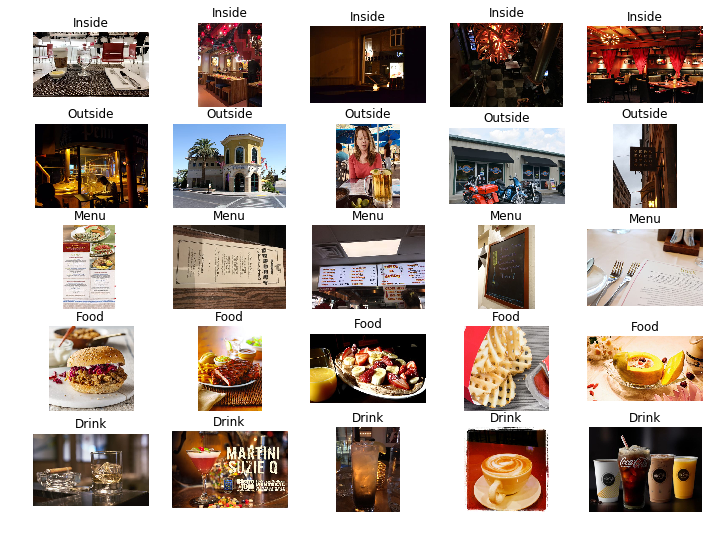

In [11]:
show_training_images()

# Step 3: Prepare Images for Inception V3 model - Data Preprocessing part 2/2

In [12]:
# Reduce images into 299 x 299
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32
EPOCHS = 5

def preprocess_image_data_for_inception_v3():

    data_train = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    data_validation = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    train_generator = data_train.flow_from_directory(
        TRAIN_DIR,
        target_size=(HEIGHT, WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    validation_generator = data_validation.flow_from_directory(
        TEST_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    return train_generator, validation_generator

In [13]:
train_generator, validation_generator = preprocess_image_data_for_inception_v3()
(X_train, Y_train) = train_generator.next()
(X_val, Y_val) = validation_generator.next()

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.


# Step 4: Build and fit Inception V3 model

In [14]:
''' Reference : https://keras.io/applications/#build-inceptionv3-over-a-custom-input-tensor '''
from talos.model.normalizers import lr_normalizer

# Build inception v3 model and save it
def build_inception_v3_model(x, y, X_val, Y_val, params):
    CLASSES = 5
    VALIDATION_STEPS = 64
    
    # Step 1: Create imagenet pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Step 2: Add an average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.4)(x)

    # Step 3: Add a logistic layer - 5 classes for 5 labels: drink, outside, inside, food, menu
    predictions = Dense(CLASSES, activation=params['activation'])(x)

    # Step 4: Create the model for training
    model = Model(inputs=base_model.input, outputs=predictions)

    # Step 5: Transfer learning. Freeze the convolutional layers. We will only train the top layers
    for layer in base_model.layers:
        layer.trainable = False
        
     

    # Step 6: Compile the model. Our loss function is based on cross entropy
    model.compile(optimizer=params['optimizer'](lr_normalizer(params['learning_rate'], params['optimizer'])), 
                  loss=params['losses'], metrics=['accuracy'])
    
    # Step 7: Preprocess and transform image data
    train_generator, validation_generator = preprocess_image_data_for_inception_v3()
    
    # Step 8: Fit the model and save it
    history = model.fit_generator(
    train_generator,
    epochs=params['epochs'],
    steps_per_epoch=params['batch_size'],
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
    
    model.save(MODEL_FILE)
    
    return history, model

# Step 5: Hyper tuning Model using Talos - Grid Search
Reference : https://github.com/autonomio/talos

In [15]:
import talos
from talos.model.normalizers import lr_normalizer
from keras import optimizers

MODEL_FILE = 'inception_v3_trained.model'
params = {'activation':['softmax', 'relu'],
         'optimizer': [optimizers.rmsprop, optimizers.adam],
         'losses': ['categorical_crossentropy'],
         'batch_size': [20, 32, 40],
         'epochs': [5,10],
         'learning_rate': [0.002, 0.01, 0.1]}

# history, model = build_inception_v3_model(train_generator, validation_generator, parameters, CLASSES)
# # history = model.fit_generator(
# #     train_generator,
# #     epochs=EPOCHS,
# #     steps_per_epoch=STEPS_PER_EPOCH,
# #     validation_data=validation_generator,
# #     validation_steps=VALIDATION_STEPS)
# model.save(MODEL_FILE)

# Hyper tuning parameters using Talos
scan_object = talos.Scan(x=X_train,
                         y=Y_train,
                         x_val=X_val,
                         y_val=Y_val,
                         params=params,
                         model=build_inception_v3_model,experiment_name='InceptionV3')

  0%|          | 0/72 [00:00<?, ?it/s]



Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.

Epoch 1/5
20/20 [==============================] - 178s 9s/step - loss: 1.6770 - accuracy: 0.2188 - val_loss: 1.6053 - val_accuracy: 0.1646
Epoch 2/5
20/20 [==============================] - 173s 9s/step - loss: 1.6186 - accuracy: 0.2375 - val_loss: 1.6227 - val_accuracy: 0.2007
Epoch 3/5
20/20 [==============================] - 174s 9s/step - loss: 1.6035 - accuracy: 0.2797 - val_loss: 1.6580 - val_accuracy: 0.2085
Epoch 4/5
20/20 [==============================] - 173s 9s/step - loss: 1.5848 - accuracy: 0.3141 - val_loss: 1.6365 - val_accuracy: 0.2212
Epoch 5/5
20/20 [==============================] - 171s 9s/step - loss: 1.5770 - accuracy: 0.3078 - val_loss: 1.4773 - val_accuracy: 0.2227


  1%|▏         | 1/72 [14:56<17:40:48, 896.46s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 174s 9s/step - loss: 1.7984 - accuracy: 0.1875 - val_loss: 2.0153 - val_accuracy: 0.1328
Epoch 2/5
20/20 [==============================] - 171s 9s/step - loss: 1.7885 - accuracy: 0.1703 - val_loss: 1.8616 - val_accuracy: 0.1357
Epoch 3/5
20/20 [==============================] - 171s 9s/step - loss: 1.7792 - accuracy: 0.1781 - val_loss: 1.8528 - val_accuracy: 0.1670
Epoch 4/5
20/20 [==============================] - 171s 9s/step - loss: 1.7264 - accuracy: 0.2172 - val_loss: 1.7759 - val_accuracy: 0.1587
Epoch 5/5
20/20 [==============================] - 171s 9s/step - loss: 1.7379 - accuracy: 0.2344 - val_loss: 1.8099 - val_accuracy: 0.1816


  3%|▎         | 2/72 [29:42<17:22:13, 893.33s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 174s 9s/step - loss: 1.5472 - accuracy: 0.3000 - val_loss: 1.4847 - val_accuracy: 0.2705
Epoch 2/5
20/20 [==============================] - 171s 9s/step - loss: 1.4873 - accuracy: 0.3328 - val_loss: 1.4673 - val_accuracy: 0.3311
Epoch 3/5
20/20 [==============================] - 171s 9s/step - loss: 1.3802 - accuracy: 0.3922 - val_loss: 1.2485 - val_accuracy: 0.3774
Epoch 4/5
20/20 [==============================] - 170s 9s/step - loss: 1.3228 - accuracy: 0.4141 - val_loss: 1.3392 - val_accuracy: 0.4233
Epoch 5/5
20/20 [==============================] - 170s 9s/step - loss: 1.3194 - accuracy: 0.4391 - val_loss: 1.3121 - val_accuracy: 0.4893


  4%|▍         | 3/72 [44:26<17:04:13, 890.62s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 174s 9s/step - loss: 1.5370 - accuracy: 0.3266 - val_loss: 1.5117 - val_accuracy: 0.2510
Epoch 2/5
20/20 [==============================] - 172s 9s/step - loss: 1.4739 - accuracy: 0.3953 - val_loss: 1.4663 - val_accuracy: 0.3481
Epoch 3/5
20/20 [==============================] - 170s 8s/step - loss: 1.3754 - accuracy: 0.4453 - val_loss: 1.5840 - val_accuracy: 0.3828
Epoch 4/5
20/20 [==============================] - 170s 8s/step - loss: 1.3874 - accuracy: 0.4734 - val_loss: 1.5328 - val_accuracy: 0.4438
Epoch 5/5
20/20 [==============================] - 170s 8s/step - loss: 1.3213 - accuracy: 0.5016 - val_loss: 1.3380 - val_accuracy: 0.4707


  6%|▌         | 4/72 [59:10<16:46:58, 888.51s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 174s 9s/step - loss: 1.2420 - accuracy: 0.5016 - val_loss: 1.2691 - val_accuracy: 0.5938
Epoch 2/5
20/20 [==============================] - 170s 9s/step - loss: 1.0906 - accuracy: 0.5500 - val_loss: 0.8587 - val_accuracy: 0.6519
Epoch 3/5
20/20 [==============================] - 170s 9s/step - loss: 1.0625 - accuracy: 0.5938 - val_loss: 0.8551 - val_accuracy: 0.6650
Epoch 4/5
20/20 [==============================] - 170s 9s/step - loss: 0.9173 - accuracy: 0.6719 - val_loss: 0.7397 - val_accuracy: 0.6367
Epoch 5/5
20/20 [==============================] - 170s 9s/step - loss: 0.9721 - accuracy: 0.6516 - val_loss: 1.0032 - val_accuracy: 0.6621


  7%|▋         | 5/72 [1:13:53<16:30:18, 886.85s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 174s 9s/step - loss: 1.4997 - accuracy: 0.4422 - val_loss: 1.6987 - val_accuracy: 0.5728
Epoch 2/5
20/20 [==============================] - 171s 9s/step - loss: 1.2147 - accuracy: 0.5344 - val_loss: 1.1888 - val_accuracy: 0.5840
Epoch 3/5
20/20 [==============================] - 170s 9s/step - loss: 1.2020 - accuracy: 0.5688 - val_loss: 1.0519 - val_accuracy: 0.5737
Epoch 4/5
20/20 [==============================] - 170s 9s/step - loss: 1.1011 - accuracy: 0.6016 - val_loss: 1.1066 - val_accuracy: 0.6567
Epoch 5/5
20/20 [==============================] - 170s 9s/step - loss: 0.9677 - accuracy: 0.6531 - val_loss: 1.2103 - val_accuracy: 0.6445


  8%|▊         | 6/72 [1:28:37<16:14:40, 886.07s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 173s 9s/step - loss: 1.8535 - accuracy: 0.1672 - val_loss: 1.8291 - val_accuracy: 0.1152
Epoch 2/10
20/20 [==============================] - 170s 9s/step - loss: 1.8192 - accuracy: 0.1672 - val_loss: 1.9869 - val_accuracy: 0.1138
Epoch 3/10
20/20 [==============================] - 171s 9s/step - loss: 1.7894 - accuracy: 0.1969 - val_loss: 1.7538 - val_accuracy: 0.1343
Epoch 4/10
20/20 [==============================] - 171s 9s/step - loss: 1.7598 - accuracy: 0.1969 - val_loss: 1.7545 - val_accuracy: 0.1392
Epoch 5/10
20/20 [==============================] - 171s 9s/step - loss: 1.7471 - accuracy: 0.2078 - val_loss: 1.7217 - val_accuracy: 0.1460
Epoch 6/10
20/20 [==============================] - 171s 9s/step - loss: 1.7056 - accuracy: 0.1844 - val_loss: 1.8945 - val_accuracy: 0.1577
Epoch 7/10
20/20 [==============================] - 171s 9s/step - 

 10%|▉         | 7/72 [1:57:38<20:37:34, 1142.38s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 175s 9s/step - loss: 2.1013 - accuracy: 0.1297 - val_loss: 1.8538 - val_accuracy: 0.0835
Epoch 2/10
20/20 [==============================] - 171s 9s/step - loss: 2.0259 - accuracy: 0.1656 - val_loss: 1.9408 - val_accuracy: 0.0850
Epoch 3/10
20/20 [==============================] - 171s 9s/step - loss: 2.0775 - accuracy: 0.1422 - val_loss: 1.8243 - val_accuracy: 0.0869
Epoch 4/10
20/20 [==============================] - 171s 9s/step - loss: 1.9811 - accuracy: 0.1906 - val_loss: 1.8920 - val_accuracy: 0.0952
Epoch 5/10
20/20 [==============================] - 171s 9s/step - loss: 2.0230 - accuracy: 0.1437 - val_loss: 1.8788 - val_accuracy: 0.1060
Epoch 6/10
20/20 [==============================] - 171s 9s/step - loss: 1.9872 - accuracy: 0.1437 - val_loss: 1.8189 - val_accuracy: 0.1157
Epoch 7/10
20/20 [==============================] - 171s 9s/step - 

 11%|█         | 8/72 [2:26:39<23:30:21, 1322.21s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 175s 9s/step - loss: 1.5002 - accuracy: 0.3391 - val_loss: 1.3359 - val_accuracy: 0.4009
Epoch 2/10
20/20 [==============================] - 171s 9s/step - loss: 1.4284 - accuracy: 0.3609 - val_loss: 1.2534 - val_accuracy: 0.4502
Epoch 3/10
20/20 [==============================] - 172s 9s/step - loss: 1.3633 - accuracy: 0.4062 - val_loss: 1.2731 - val_accuracy: 0.4858
Epoch 4/10
20/20 [==============================] - 171s 9s/step - loss: 1.3192 - accuracy: 0.4797 - val_loss: 1.2594 - val_accuracy: 0.5439
Epoch 5/10
20/20 [==============================] - 171s 9s/step - loss: 1.2649 - accuracy: 0.5094 - val_loss: 1.2392 - val_accuracy: 0.5488
Epoch 6/10
20/20 [==============================] - 170s 9s/step - loss: 1.2549 - accuracy: 0.4953 - val_loss: 1.0517 - val_accuracy: 0.5703
Epoch 7/10
20/20 [==============================] - 170s 9s/step - 

 12%|█▎        | 9/72 [2:55:39<25:19:55, 1447.55s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 174s 9s/step - loss: 1.7085 - accuracy: 0.2031 - val_loss: 1.6068 - val_accuracy: 0.1680
Epoch 2/10
20/20 [==============================] - 170s 8s/step - loss: 1.6591 - accuracy: 0.2344 - val_loss: 1.6238 - val_accuracy: 0.2905
Epoch 3/10
20/20 [==============================] - 171s 9s/step - loss: 1.5372 - accuracy: 0.3078 - val_loss: 1.4989 - val_accuracy: 0.3838
Epoch 4/10
20/20 [==============================] - 170s 9s/step - loss: 1.4598 - accuracy: 0.3625 - val_loss: 1.4318 - val_accuracy: 0.4307
Epoch 5/10
20/20 [==============================] - 170s 8s/step - loss: 1.4007 - accuracy: 0.4047 - val_loss: 1.3025 - val_accuracy: 0.4902
Epoch 6/10
20/20 [==============================] - 170s 8s/step - loss: 1.3300 - accuracy: 0.4609 - val_loss: 1.3972 - val_accuracy: 0.5181
Epoch 7/10
20/20 [==============================] - 170s 8s/step - 

 14%|█▍        | 10/72 [3:24:35<26:25:01, 1533.90s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 174s 9s/step - loss: 1.2964 - accuracy: 0.4844 - val_loss: 1.2058 - val_accuracy: 0.5728
Epoch 2/10
20/20 [==============================] - 170s 9s/step - loss: 1.1085 - accuracy: 0.5969 - val_loss: 1.4454 - val_accuracy: 0.5820
Epoch 3/10
20/20 [==============================] - 170s 9s/step - loss: 1.0547 - accuracy: 0.6172 - val_loss: 0.9639 - val_accuracy: 0.6289
Epoch 4/10
20/20 [==============================] - 171s 9s/step - loss: 0.9679 - accuracy: 0.6375 - val_loss: 1.0100 - val_accuracy: 0.6558
Epoch 5/10
20/20 [==============================] - 170s 9s/step - loss: 0.9615 - accuracy: 0.6453 - val_loss: 1.0307 - val_accuracy: 0.6992
Epoch 6/10
20/20 [==============================] - 170s 9s/step - loss: 0.8689 - accuracy: 0.6984 - val_loss: 0.8563 - val_accuracy: 0.6743
Epoch 7/10
20/20 [==============================] - 171s 9s/step - 

 15%|█▌        | 11/72 [3:53:34<27:02:14, 1595.65s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 174s 9s/step - loss: 1.6472 - accuracy: 0.2781 - val_loss: 1.3013 - val_accuracy: 0.5508
Epoch 2/10
20/20 [==============================] - 171s 9s/step - loss: 1.1653 - accuracy: 0.5469 - val_loss: 1.1519 - val_accuracy: 0.5933
Epoch 3/10
20/20 [==============================] - 170s 9s/step - loss: 1.1301 - accuracy: 0.5766 - val_loss: 1.1465 - val_accuracy: 0.5688
Epoch 4/10
20/20 [==============================] - 170s 9s/step - loss: 1.0833 - accuracy: 0.6094 - val_loss: 0.8657 - val_accuracy: 0.5903
Epoch 5/10
20/20 [==============================] - 170s 9s/step - loss: 1.0322 - accuracy: 0.6344 - val_loss: 1.1152 - val_accuracy: 0.5874
Epoch 6/10
20/20 [==============================] - 170s 9s/step - loss: 1.0005 - accuracy: 0.6516 - val_loss: 0.9376 - val_accuracy: 0.6318
Epoch 7/10
20/20 [==============================] - 171s 9s/step - 

 17%|█▋        | 12/72 [4:22:33<27:18:21, 1638.37s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: 1.5232 - accuracy: 0.2539 - val_loss: 1.5505 - val_accuracy: 0.1982
Epoch 2/5
32/32 [==============================] - 193s 6s/step - loss: 1.5455 - accuracy: 0.2617 - val_loss: 1.2988 - val_accuracy: 0.2246
Epoch 3/5
32/32 [==============================] - 193s 6s/step - loss: 1.4831 - accuracy: 0.3018 - val_loss: 1.3457 - val_accuracy: 0.2622
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 1.4683 - accuracy: 0.3184 - val_loss: 1.4816 - val_accuracy: 0.2759
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 1.4733 - accuracy: 0.3057 - val_loss: 1.3491 - val_accuracy: 0.3130


 18%|█▊        | 13/72 [4:39:10<23:42:00, 1446.10s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 196s 6s/step - loss: 1.6479 - accuracy: 0.2363 - val_loss: 1.6433 - val_accuracy: 0.2710
Epoch 2/5
32/32 [==============================] - 193s 6s/step - loss: 1.6245 - accuracy: 0.2490 - val_loss: 1.4437 - val_accuracy: 0.2788
Epoch 3/5
32/32 [==============================] - 193s 6s/step - loss: 1.6334 - accuracy: 0.2578 - val_loss: 1.6686 - val_accuracy: 0.2822
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 1.6411 - accuracy: 0.2256 - val_loss: 1.3850 - val_accuracy: 0.2964
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 1.5970 - accuracy: 0.2598 - val_loss: 1.5050 - val_accuracy: 0.2847


 19%|█▉        | 14/72 [4:55:47<21:07:36, 1311.32s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: 2.0407 - accuracy: 0.1104 - val_loss: 1.9250 - val_accuracy: 0.1401
Epoch 2/5
32/32 [==============================] - 193s 6s/step - loss: 1.7789 - accuracy: 0.1973 - val_loss: 1.6860 - val_accuracy: 0.2549
Epoch 3/5
32/32 [==============================] - 194s 6s/step - loss: 1.6631 - accuracy: 0.2090 - val_loss: 1.5736 - val_accuracy: 0.4033
Epoch 4/5
32/32 [==============================] - 194s 6s/step - loss: 1.5428 - accuracy: 0.2920 - val_loss: 1.2624 - val_accuracy: 0.5137
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 1.4432 - accuracy: 0.3672 - val_loss: 1.2362 - val_accuracy: 0.5571


 21%|██        | 15/72 [5:12:27<19:17:04, 1217.97s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: 1.3993 - accuracy: 0.4707 - val_loss: 1.1812 - val_accuracy: 0.5483
Epoch 2/5
32/32 [==============================] - 193s 6s/step - loss: 1.3129 - accuracy: 0.5059 - val_loss: 1.3825 - val_accuracy: 0.5601
Epoch 3/5
32/32 [==============================] - 194s 6s/step - loss: 1.3094 - accuracy: 0.4951 - val_loss: 1.1074 - val_accuracy: 0.5547
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 1.2510 - accuracy: 0.5254 - val_loss: 1.2855 - val_accuracy: 0.5459
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 1.2227 - accuracy: 0.5430 - val_loss: 1.4498 - val_accuracy: 0.5654


 22%|██▏       | 16/72 [5:29:06<17:55:33, 1152.38s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: 1.3883 - accuracy: 0.4473 - val_loss: 1.2709 - val_accuracy: 0.5596
Epoch 2/5
32/32 [==============================] - 194s 6s/step - loss: 1.1205 - accuracy: 0.5762 - val_loss: 1.0474 - val_accuracy: 0.5874
Epoch 3/5
32/32 [==============================] - 194s 6s/step - loss: 1.0241 - accuracy: 0.6172 - val_loss: 0.9634 - val_accuracy: 0.6479
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 0.9116 - accuracy: 0.7021 - val_loss: 0.6666 - val_accuracy: 0.6455
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 0.9243 - accuracy: 0.6865 - val_loss: 1.1242 - val_accuracy: 0.7349


 24%|██▎       | 17/72 [5:45:48<16:54:47, 1107.05s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: 1.4053 - accuracy: 0.4170 - val_loss: 1.1195 - val_accuracy: 0.6084
Epoch 2/5
32/32 [==============================] - 194s 6s/step - loss: 1.0678 - accuracy: 0.6094 - val_loss: 1.0734 - val_accuracy: 0.6519
Epoch 3/5
32/32 [==============================] - 194s 6s/step - loss: 1.0128 - accuracy: 0.6348 - val_loss: 0.5263 - val_accuracy: 0.7437
Epoch 4/5
32/32 [==============================] - 193s 6s/step - loss: 0.9716 - accuracy: 0.6748 - val_loss: 0.6562 - val_accuracy: 0.7368
Epoch 5/5
32/32 [==============================] - 193s 6s/step - loss: 0.8567 - accuracy: 0.7178 - val_loss: 0.7994 - val_accuracy: 0.7373


 25%|██▌       | 18/72 [6:02:29<16:07:50, 1075.37s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 197s 6s/step - loss: 1.9070 - accuracy: 0.1270 - val_loss: 1.8372 - val_accuracy: 0.0845
Epoch 2/10
32/32 [==============================] - 192s 6s/step - loss: 1.8579 - accuracy: 0.1357 - val_loss: 1.8943 - val_accuracy: 0.1016
Epoch 3/10
32/32 [==============================] - 192s 6s/step - loss: 1.7913 - accuracy: 0.1689 - val_loss: 1.7402 - val_accuracy: 0.1206
Epoch 4/10
32/32 [==============================] - 192s 6s/step - loss: 1.7834 - accuracy: 0.1670 - val_loss: 1.8803 - val_accuracy: 0.1348
Epoch 5/10
32/32 [==============================] - 192s 6s/step - loss: 1.7574 - accuracy: 0.1826 - val_loss: 1.6527 - val_accuracy: 0.1514
Epoch 6/10
32/32 [==============================] - 192s 6s/step - loss: 1.7370 - accuracy: 0.2021 - val_loss: 1.6555 - val_accuracy: 0.2095
Epoch 7/10
32/32 [==============================] - 192s 6s/step - 

 26%|██▋       | 19/72 [6:35:05<19:43:09, 1339.42s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 197s 6s/step - loss: 1.8335 - accuracy: 0.1641 - val_loss: 1.7142 - val_accuracy: 0.1865
Epoch 2/10
32/32 [==============================] - 193s 6s/step - loss: 1.8146 - accuracy: 0.1660 - val_loss: 1.8197 - val_accuracy: 0.1997
Epoch 3/10
32/32 [==============================] - 193s 6s/step - loss: 1.7251 - accuracy: 0.2012 - val_loss: 1.6614 - val_accuracy: 0.2104
Epoch 4/10
32/32 [==============================] - 193s 6s/step - loss: 1.7381 - accuracy: 0.1777 - val_loss: 1.5382 - val_accuracy: 0.2275
Epoch 5/10
32/32 [==============================] - 193s 6s/step - loss: 1.7278 - accuracy: 0.2197 - val_loss: 1.4944 - val_accuracy: 0.2754
Epoch 6/10
32/32 [==============================] - 193s 6s/step - loss: 1.6903 - accuracy: 0.2275 - val_loss: 1.5904 - val_accuracy: 0.3032
Epoch 7/10
32/32 [==============================] - 193s 6s/step - 

 28%|██▊       | 20/72 [7:07:51<22:03:48, 1527.47s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 195s 6s/step - loss: 1.7395 - accuracy: 0.1885 - val_loss: 1.6344 - val_accuracy: 0.2109
Epoch 2/10
32/32 [==============================] - 192s 6s/step - loss: 1.5633 - accuracy: 0.2998 - val_loss: 1.3643 - val_accuracy: 0.3623
Epoch 3/10
32/32 [==============================] - 192s 6s/step - loss: 1.4383 - accuracy: 0.3896 - val_loss: 1.3909 - val_accuracy: 0.4678
Epoch 4/10
32/32 [==============================] - 192s 6s/step - loss: 1.3838 - accuracy: 0.4199 - val_loss: 1.3885 - val_accuracy: 0.5386
Epoch 5/10
32/32 [==============================] - 192s 6s/step - loss: 1.3221 - accuracy: 0.5039 - val_loss: 1.2605 - val_accuracy: 0.5498
Epoch 6/10
32/32 [==============================] - 192s 6s/step - loss: 1.2789 - accuracy: 0.5098 - val_loss: 1.2878 - val_accuracy: 0.5591
Epoch 7/10
32/32 [==============================] - 192s 6s/step - 

 29%|██▉       | 21/72 [7:40:27<23:27:39, 1656.07s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 198s 6s/step - loss: 1.5177 - accuracy: 0.3018 - val_loss: 1.4437 - val_accuracy: 0.2466
Epoch 2/10
32/32 [==============================] - 194s 6s/step - loss: 1.4603 - accuracy: 0.3457 - val_loss: 1.2711 - val_accuracy: 0.3770
Epoch 3/10
32/32 [==============================] - 194s 6s/step - loss: 1.3922 - accuracy: 0.4092 - val_loss: 1.3816 - val_accuracy: 0.4243
Epoch 4/10
32/32 [==============================] - 194s 6s/step - loss: 1.3331 - accuracy: 0.4512 - val_loss: 1.2556 - val_accuracy: 0.4868
Epoch 5/10
32/32 [==============================] - 194s 6s/step - loss: 1.2474 - accuracy: 0.5137 - val_loss: 1.2085 - val_accuracy: 0.5005
Epoch 6/10
32/32 [==============================] - 195s 6s/step - loss: 1.2316 - accuracy: 0.5098 - val_loss: 1.0768 - val_accuracy: 0.5566
Epoch 7/10
32/32 [==============================] - 194s 6s/step - 

 31%|███       | 22/72 [8:13:23<24:20:02, 1752.04s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 197s 6s/step - loss: 1.3105 - accuracy: 0.5068 - val_loss: 1.2493 - val_accuracy: 0.6045
Epoch 2/10
32/32 [==============================] - 194s 6s/step - loss: 1.1215 - accuracy: 0.5928 - val_loss: 0.7980 - val_accuracy: 0.6719
Epoch 3/10
32/32 [==============================] - 194s 6s/step - loss: 0.9757 - accuracy: 0.6729 - val_loss: 0.9553 - val_accuracy: 0.6528
Epoch 4/10
32/32 [==============================] - 194s 6s/step - loss: 0.9187 - accuracy: 0.6934 - val_loss: 0.6435 - val_accuracy: 0.7334
Epoch 5/10
32/32 [==============================] - 194s 6s/step - loss: 0.8174 - accuracy: 0.7354 - val_loss: 1.1199 - val_accuracy: 0.7510
Epoch 6/10
32/32 [==============================] - 194s 6s/step - loss: 0.7840 - accuracy: 0.7529 - val_loss: 0.8362 - val_accuracy: 0.7510
Epoch 7/10
32/32 [==============================] - 194s 6s/step - 

 32%|███▏      | 23/72 [8:46:16<24:44:57, 1818.32s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 197s 6s/step - loss: 1.4664 - accuracy: 0.3965 - val_loss: 1.2889 - val_accuracy: 0.6113
Epoch 2/10
32/32 [==============================] - 194s 6s/step - loss: 1.0591 - accuracy: 0.6152 - val_loss: 0.9724 - val_accuracy: 0.6401
Epoch 3/10
32/32 [==============================] - 194s 6s/step - loss: 1.0147 - accuracy: 0.6484 - val_loss: 1.0987 - val_accuracy: 0.7202
Epoch 4/10
32/32 [==============================] - 194s 6s/step - loss: 0.9625 - accuracy: 0.6807 - val_loss: 1.4846 - val_accuracy: 0.7271
Epoch 5/10
32/32 [==============================] - 194s 6s/step - loss: 0.8605 - accuracy: 0.7188 - val_loss: 0.5617 - val_accuracy: 0.7461
Epoch 6/10
32/32 [==============================] - 194s 6s/step - loss: 0.8623 - accuracy: 0.7197 - val_loss: 0.6292 - val_accuracy: 0.7686
Epoch 7/10
32/32 [==============================] - 194s 6s/step - 

 33%|███▎      | 24/72 [9:19:06<24:51:11, 1863.99s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 211s 5s/step - loss: 1.9707 - accuracy: 0.1000 - val_loss: 1.9862 - val_accuracy: 0.0835
Epoch 2/5
40/40 [==============================] - 207s 5s/step - loss: 1.9135 - accuracy: 0.1189 - val_loss: 1.9239 - val_accuracy: 0.0908
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: 1.8687 - accuracy: 0.1289 - val_loss: 1.9066 - val_accuracy: 0.1011
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: 1.8320 - accuracy: 0.1445 - val_loss: 1.8023 - val_accuracy: 0.1245
Epoch 5/5
40/40 [==============================] - 207s 5s/step - loss: 1.7802 - accuracy: 0.1867 - val_loss: 1.8038 - val_accuracy: 0.1235


 35%|███▍      | 25/72 [9:36:57<21:13:45, 1626.08s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 211s 5s/step - loss: 1.7979 - accuracy: 0.1820 - val_loss: 1.6908 - val_accuracy: 0.1675
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: 1.7739 - accuracy: 0.1828 - val_loss: 1.6380 - val_accuracy: 0.1797
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: 1.7114 - accuracy: 0.2094 - val_loss: 1.6634 - val_accuracy: 0.2222
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: 1.6708 - accuracy: 0.2242 - val_loss: 1.6260 - val_accuracy: 0.2739
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: 1.6329 - accuracy: 0.2570 - val_loss: 1.6087 - val_accuracy: 0.3022


 36%|███▌      | 26/72 [9:54:50<18:39:24, 1460.11s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 213s 5s/step - loss: 1.8234 - accuracy: 0.1742 - val_loss: 1.8006 - val_accuracy: 0.1167
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: 1.6565 - accuracy: 0.2211 - val_loss: 1.6147 - val_accuracy: 0.2070
Epoch 3/5
40/40 [==============================] - 209s 5s/step - loss: 1.5026 - accuracy: 0.3281 - val_loss: 1.4536 - val_accuracy: 0.3062
Epoch 4/5
40/40 [==============================] - 210s 5s/step - loss: 1.3994 - accuracy: 0.3773 - val_loss: 1.3490 - val_accuracy: 0.4453
Epoch 5/5
40/40 [==============================] - 209s 5s/step - loss: 1.2914 - accuracy: 0.4625 - val_loss: 1.2792 - val_accuracy: 0.4995


 38%|███▊      | 27/72 [10:12:48<16:49:03, 1345.42s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 211s 5s/step - loss: 1.4446 - accuracy: 0.3836 - val_loss: 1.3599 - val_accuracy: 0.5815
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: 1.3005 - accuracy: 0.4852 - val_loss: 1.4886 - val_accuracy: 0.6089
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: 1.2424 - accuracy: 0.5329 - val_loss: 1.0906 - val_accuracy: 0.6211
Epoch 4/5
40/40 [==============================] - 209s 5s/step - loss: 1.1941 - accuracy: 0.5531 - val_loss: 1.1903 - val_accuracy: 0.6040
Epoch 5/5
40/40 [==============================] - 209s 5s/step - loss: 1.2016 - accuracy: 0.5414 - val_loss: 1.0573 - val_accuracy: 0.6270


 39%|███▉      | 28/72 [10:30:43<15:27:14, 1264.41s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 212s 5s/step - loss: 1.3016 - accuracy: 0.4789 - val_loss: 1.1415 - val_accuracy: 0.5840
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: 1.0180 - accuracy: 0.6141 - val_loss: 0.6793 - val_accuracy: 0.6323
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: 0.9474 - accuracy: 0.6750 - val_loss: 0.7159 - val_accuracy: 0.7085
Epoch 4/5
40/40 [==============================] - 209s 5s/step - loss: 0.8448 - accuracy: 0.7086 - val_loss: 0.7444 - val_accuracy: 0.6953
Epoch 5/5
40/40 [==============================] - 209s 5s/step - loss: 0.7378 - accuracy: 0.7641 - val_loss: 1.0285 - val_accuracy: 0.7598


 40%|████      | 29/72 [10:48:38<14:25:24, 1207.56s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 212s 5s/step - loss: 1.2596 - accuracy: 0.5172 - val_loss: 0.8951 - val_accuracy: 0.5962
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: 1.0646 - accuracy: 0.6187 - val_loss: 0.9340 - val_accuracy: 0.6191
Epoch 3/5
40/40 [==============================] - 209s 5s/step - loss: 0.9946 - accuracy: 0.6570 - val_loss: 0.8343 - val_accuracy: 0.6729
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: 0.8687 - accuracy: 0.6922 - val_loss: 0.3954 - val_accuracy: 0.7393
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: 0.8207 - accuracy: 0.7266 - val_loss: 0.6957 - val_accuracy: 0.7227


 42%|████▏     | 30/72 [11:06:33<13:37:20, 1167.64s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: 1.4846 - accuracy: 0.4008 - val_loss: 1.3995 - val_accuracy: 0.5161
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: 1.4683 - accuracy: 0.4062 - val_loss: 1.2485 - val_accuracy: 0.5483
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: 1.4385 - accuracy: 0.4250 - val_loss: 1.3805 - val_accuracy: 0.5479
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: 1.4103 - accuracy: 0.4500 - val_loss: 1.5542 - val_accuracy: 0.5376
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: 1.3933 - accuracy: 0.4664 - val_loss: 1.3031 - val_accuracy: 0.5635
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 1.3601 - accuracy: 0.4914 - val_loss: 1.4367 - val_accuracy: 0.5698
Epoch 7/10
40/40 [==============================] - 208s 5s/step - 

 43%|████▎     | 31/72 [11:41:44<16:31:18, 1450.70s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: 1.6379 - accuracy: 0.2383 - val_loss: 1.6490 - val_accuracy: 0.1626
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: 1.5997 - accuracy: 0.2562 - val_loss: 1.6042 - val_accuracy: 0.1855
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: 1.5979 - accuracy: 0.2594 - val_loss: 1.5512 - val_accuracy: 0.1992
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: 1.5654 - accuracy: 0.2922 - val_loss: 1.5482 - val_accuracy: 0.2314
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: 1.5310 - accuracy: 0.3203 - val_loss: 1.5841 - val_accuracy: 0.2769
Epoch 6/10
40/40 [==============================] - 207s 5s/step - loss: 1.5051 - accuracy: 0.3141 - val_loss: 1.5007 - val_accuracy: 0.2559
Epoch 7/10
40/40 [==============================] - 208s 5s/step - 

 44%|████▍     | 32/72 [12:16:57<18:19:37, 1649.44s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 211s 5s/step - loss: 1.4332 - accuracy: 0.3805 - val_loss: 1.0124 - val_accuracy: 0.5444
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: 1.3266 - accuracy: 0.4328 - val_loss: 1.2887 - val_accuracy: 0.5664
Epoch 3/10
40/40 [==============================] - 207s 5s/step - loss: 1.2957 - accuracy: 0.4570 - val_loss: 1.1594 - val_accuracy: 0.5952
Epoch 4/10
40/40 [==============================] - 207s 5s/step - loss: 1.2215 - accuracy: 0.5125 - val_loss: 1.1713 - val_accuracy: 0.6011
Epoch 5/10
40/40 [==============================] - 207s 5s/step - loss: 1.1639 - accuracy: 0.5555 - val_loss: 1.2434 - val_accuracy: 0.5713
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 1.1486 - accuracy: 0.5477 - val_loss: 0.9681 - val_accuracy: 0.5957
Epoch 7/10
40/40 [==============================] - 207s 5s/step - 

 46%|████▌     | 33/72 [12:52:03<19:21:11, 1786.45s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: 1.7720 - accuracy: 0.1859 - val_loss: 1.6955 - val_accuracy: 0.2090
Epoch 2/10
40/40 [==============================] - 209s 5s/step - loss: 1.6125 - accuracy: 0.2695 - val_loss: 1.5408 - val_accuracy: 0.3574
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: 1.4898 - accuracy: 0.3680 - val_loss: 1.3285 - val_accuracy: 0.4658
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: 1.3924 - accuracy: 0.4391 - val_loss: 1.3721 - val_accuracy: 0.5063
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: 1.3269 - accuracy: 0.4672 - val_loss: 1.2271 - val_accuracy: 0.5508
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 1.3261 - accuracy: 0.4781 - val_loss: 1.4499 - val_accuracy: 0.5630
Epoch 7/10
40/40 [==============================] - 208s 5s/step - 

 47%|████▋     | 34/72 [13:27:19<19:53:53, 1885.08s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 213s 5s/step - loss: 1.2465 - accuracy: 0.5234 - val_loss: 1.3115 - val_accuracy: 0.6147
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: 1.0857 - accuracy: 0.6023 - val_loss: 0.6608 - val_accuracy: 0.7061
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: 0.9612 - accuracy: 0.6672 - val_loss: 0.9836 - val_accuracy: 0.7251
Epoch 4/10
40/40 [==============================] - 209s 5s/step - loss: 0.9073 - accuracy: 0.6914 - val_loss: 0.7113 - val_accuracy: 0.7524
Epoch 5/10
40/40 [==============================] - 209s 5s/step - loss: 0.8678 - accuracy: 0.7211 - val_loss: 0.4583 - val_accuracy: 0.7837
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 0.7559 - accuracy: 0.7516 - val_loss: 1.0803 - val_accuracy: 0.7876
Epoch 7/10
40/40 [==============================] - 208s 5s/step - 

 49%|████▊     | 35/72 [14:02:56<20:09:09, 1960.80s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 221s 6s/step - loss: 1.2263 - accuracy: 0.5383 - val_loss: 1.5387 - val_accuracy: 0.5776
Epoch 2/10
40/40 [==============================] - 211s 5s/step - loss: 0.9723 - accuracy: 0.6523 - val_loss: 1.1889 - val_accuracy: 0.6191
Epoch 3/10
40/40 [==============================] - 209s 5s/step - loss: 0.9563 - accuracy: 0.6422 - val_loss: 0.9535 - val_accuracy: 0.7168
Epoch 4/10
40/40 [==============================] - 207s 5s/step - loss: 0.8791 - accuracy: 0.7039 - val_loss: 0.7620 - val_accuracy: 0.6846
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: 0.8004 - accuracy: 0.7469 - val_loss: 0.6586 - val_accuracy: 0.7339
Epoch 6/10
40/40 [==============================] - 229s 6s/step - loss: 0.8183 - accuracy: 0.7227 - val_loss: 0.7705 - val_accuracy: 0.7524
Epoch 7/10
40/40 [==============================] - 214s 5s/step - 

 50%|█████     | 36/72 [14:39:35<20:19:17, 2032.15s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
20/20 [==============================] - 188s 9s/step - loss: nan - accuracy: 0.1656 - val_loss: nan - val_accuracy: 0.0908
Epoch 2/5
20/20 [==============================] - 183s 9s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0908
Epoch 3/5
20/20 [==============================] - 190s 9s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.1060
Epoch 4/5
20/20 [==============================] - 183s 9s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0835
Epoch 5/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0947


 51%|█████▏    | 37/72 [14:55:31<16:37:08, 1709.38s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 183s 9s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0903
Epoch 2/5
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.1031 - val_loss: nan - val_accuracy: 0.0981
Epoch 3/5
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0984 - val_loss: nan - val_accuracy: 0.0840
Epoch 4/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0854
Epoch 5/5
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0938


 53%|█████▎    | 38/72 [15:11:05<13:56:49, 1476.74s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 193s 10s/step - loss: 8.2759 - accuracy: 0.1547 - val_loss: 6.3249 - val_accuracy: 0.2046
Epoch 2/5
20/20 [==============================] - 187s 9s/step - loss: nan - accuracy: 0.1453 - val_loss: nan - val_accuracy: 0.0864
Epoch 3/5
20/20 [==============================] - 184s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0938
Epoch 4/5
20/20 [==============================] - 181s 9s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0781
Epoch 5/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0828 - val_loss: nan - val_accuracy: 0.1021


 54%|█████▍    | 39/72 [15:27:00<12:06:09, 1320.28s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 184s 9s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0884
Epoch 2/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0844 - val_loss: nan - val_accuracy: 0.0908
Epoch 3/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0953 - val_loss: nan - val_accuracy: 0.0923
Epoch 4/5
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0801
Epoch 5/5
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0903


 56%|█████▌    | 40/72 [15:42:33<10:42:12, 1204.15s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0594 - val_loss: nan - val_accuracy: 0.0859
Epoch 2/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.1016
Epoch 3/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0719 - val_loss: nan - val_accuracy: 0.0879
Epoch 4/5
20/20 [==============================] - 178s 9s/step - loss: nan - accuracy: 0.0781 - val_loss: nan - val_accuracy: 0.0933
Epoch 5/5
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0820


 57%|█████▋    | 41/72 [15:57:58<9:38:45, 1120.18s/it] 

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
20/20 [==============================] - 182s 9s/step - loss: nan - accuracy: 0.0953 - val_loss: nan - val_accuracy: 0.0845
Epoch 2/5
20/20 [==============================] - 181s 9s/step - loss: nan - accuracy: 0.0969 - val_loss: nan - val_accuracy: 0.0903
Epoch 3/5
20/20 [==============================] - 182s 9s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0845
Epoch 4/5
20/20 [==============================] - 181s 9s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0879
Epoch 5/5
20/20 [==============================] - 187s 9s/step - loss: nan - accuracy: 0.0812 - val_loss: nan - val_accuracy: 0.0884


 58%|█████▊    | 42/72 [16:13:41<8:53:31, 1067.04s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 186s 9s/step - loss: nan - accuracy: 0.1125 - val_loss: nan - val_accuracy: 0.0869
Epoch 2/10
20/20 [==============================] - 189s 9s/step - loss: nan - accuracy: 0.0797 - val_loss: nan - val_accuracy: 0.0928
Epoch 3/10
20/20 [==============================] - 177s 9s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0889
Epoch 4/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.1040
Epoch 5/10
20/20 [==============================] - 174s 9s/step - loss: nan - accuracy: 0.0797 - val_loss: nan - val_accuracy: 0.0859
Epoch 6/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.1172 - val_loss: nan - val_accuracy: 0.0942
Epoch 7/10
20/20 [==============================] - 186s 9s/step - loss: nan - accuracy: 0.1109 - val_l

 60%|█████▉    | 43/72 [16:44:33<10:29:40, 1302.77s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 188s 9s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0908
Epoch 2/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0928
Epoch 3/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.1047 - val_loss: nan - val_accuracy: 0.1016
Epoch 4/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0845
Epoch 5/10
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0864
Epoch 6/10
20/20 [==============================] - 177s 9s/step - loss: nan - accuracy: 0.1031 - val_loss: nan - val_accuracy: 0.0850
Epoch 7/10
20/20 [==============================] - 175s 9s/step - loss: nan - accuracy: 0.0859 - val_l

 61%|██████    | 44/72 [17:14:43<11:18:53, 1454.77s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 185s 9s/step - loss: nan - accuracy: 0.0812 - val_loss: nan - val_accuracy: 0.0850
Epoch 2/10
20/20 [==============================] - 178s 9s/step - loss: nan - accuracy: 0.0781 - val_loss: nan - val_accuracy: 0.0991
Epoch 3/10
20/20 [==============================] - 173s 9s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0938
Epoch 4/10
20/20 [==============================] - 177s 9s/step - loss: nan - accuracy: 0.0797 - val_loss: nan - val_accuracy: 0.0889
Epoch 5/10
20/20 [==============================] - 182s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0742
Epoch 6/10
20/20 [==============================] - 185s 9s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0967
Epoch 7/10
20/20 [==============================] - 187s 9s/step - loss: nan - accuracy: 0.0812 - val_l

 62%|██████▎   | 45/72 [17:45:26<11:47:08, 1571.44s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 184s 9s/step - loss: 8.1666 - accuracy: 0.0750 - val_loss: 7.0140 - val_accuracy: 0.0898
Epoch 2/10
20/20 [==============================] - 182s 9s/step - loss: nan - accuracy: 0.1078 - val_loss: nan - val_accuracy: 0.0903
Epoch 3/10
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0812 - val_loss: nan - val_accuracy: 0.0952
Epoch 4/10
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0797 - val_loss: nan - val_accuracy: 0.0938
Epoch 5/10
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0923
Epoch 6/10
20/20 [==============================] - 182s 9s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0854
Epoch 7/10
20/20 [==============================] - 180s 9s/step - loss: nan - accuracy: 0.0750 -

 64%|██████▍   | 46/72 [18:16:00<11:55:01, 1650.04s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 179s 9s/step - loss: nan - accuracy: 0.2750 - val_loss: nan - val_accuracy: 0.1001
Epoch 2/10
20/20 [==============================] - 173s 9s/step - loss: nan - accuracy: 0.0953 - val_loss: nan - val_accuracy: 0.0962
Epoch 3/10
20/20 [==============================] - 173s 9s/step - loss: nan - accuracy: 0.1078 - val_loss: nan - val_accuracy: 0.0903
Epoch 4/10
20/20 [==============================] - 172s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0889
Epoch 5/10
20/20 [==============================] - 172s 9s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0884
Epoch 6/10
20/20 [==============================] - 174s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0981
Epoch 7/10
20/20 [==============================] - 173s 9s/step - loss: nan - accuracy: 0.0969 - val_l

 65%|██████▌   | 47/72 [18:45:24<11:41:47, 1684.29s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
20/20 [==============================] - 176s 9s/step - loss: nan - accuracy: 0.0844 - val_loss: nan - val_accuracy: 0.0967
Epoch 2/10
20/20 [==============================] - 171s 9s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0962
Epoch 3/10
20/20 [==============================] - 172s 9s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0903
Epoch 4/10
20/20 [==============================] - 171s 9s/step - loss: nan - accuracy: 0.1047 - val_loss: nan - val_accuracy: 0.0840
Epoch 5/10
20/20 [==============================] - 171s 9s/step - loss: nan - accuracy: 0.0984 - val_loss: nan - val_accuracy: 0.0869
Epoch 6/10
20/20 [==============================] - 171s 9s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0825
Epoch 7/10
20/20 [==============================] - 172s 9s/step - loss: nan - accuracy: 0.1094 - val_l

 67%|██████▋   | 48/72 [19:14:34<11:21:32, 1703.86s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 198s 6s/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0957
Epoch 2/5
32/32 [==============================] - 198s 6s/step - loss: nan - accuracy: 0.1006 - val_loss: nan - val_accuracy: 0.1045
Epoch 3/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0815
Epoch 4/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0840 - val_loss: nan - val_accuracy: 0.0938
Epoch 5/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0850 - val_loss: nan - val_accuracy: 0.0850


 68%|██████▊   | 49/72 [19:31:23<9:33:17, 1495.54s/it] 

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 197s 6s/step - loss: nan - accuracy: 0.0908 - val_loss: nan - val_accuracy: 0.0952
Epoch 2/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0845
Epoch 3/5
32/32 [==============================] - 193s 6s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0825
Epoch 4/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0771 - val_loss: nan - val_accuracy: 0.1040
Epoch 5/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0850 - val_loss: nan - val_accuracy: 0.0938


 69%|██████▉   | 50/72 [19:48:06<8:14:12, 1347.83s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 198s 6s/step - loss: nan - accuracy: 0.1025 - val_loss: nan - val_accuracy: 0.1030
Epoch 2/5
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0830
Epoch 3/5
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0825
Epoch 4/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0977 - val_loss: nan - val_accuracy: 0.0864
Epoch 5/5
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0889 - val_loss: nan - val_accuracy: 0.0913


 71%|███████   | 51/72 [20:04:54<7:16:04, 1245.93s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 199s 6s/step - loss: nan - accuracy: 0.1006 - val_loss: nan - val_accuracy: 0.0957
Epoch 2/5
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.1074 - val_loss: nan - val_accuracy: 0.0874
Epoch 3/5
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0969 - val_loss: nan - val_accuracy: 0.0889
Epoch 4/5
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0889 - val_loss: nan - val_accuracy: 0.0889
Epoch 5/5
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0889 - val_loss: nan - val_accuracy: 0.0933


 72%|███████▏  | 52/72 [20:21:47<6:31:56, 1175.82s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 199s 6s/step - loss: 3.4079 - accuracy: 0.3916 - val_loss: 2.3320 - val_accuracy: 0.4897
Epoch 2/5
32/32 [==============================] - 196s 6s/step - loss: 2.7185 - accuracy: 0.5479 - val_loss: 2.2071 - val_accuracy: 0.5669
Epoch 3/5
32/32 [==============================] - 196s 6s/step - loss: 1.8797 - accuracy: 0.5771 - val_loss: 2.3976 - val_accuracy: 0.5894
Epoch 4/5
32/32 [==============================] - 194s 6s/step - loss: 1.7538 - accuracy: 0.6240 - val_loss: 1.0890 - val_accuracy: 0.5786
Epoch 5/5
32/32 [==============================] - 194s 6s/step - loss: 1.5552 - accuracy: 0.6299 - val_loss: 1.7300 - val_accuracy: 0.6431


 74%|███████▎  | 53/72 [20:38:38<5:56:42, 1126.46s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
32/32 [==============================] - 199s 6s/step - loss: nan - accuracy: 0.0830 - val_loss: nan - val_accuracy: 0.0864
Epoch 2/5
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0908 - val_loss: nan - val_accuracy: 0.0967
Epoch 3/5
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0830 - val_loss: nan - val_accuracy: 0.0923
Epoch 4/5
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0811 - val_loss: nan - val_accuracy: 0.0781
Epoch 5/5
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0801 - val_loss: nan - val_accuracy: 0.0967


 75%|███████▌  | 54/72 [20:55:30<5:27:36, 1092.03s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 198s 6s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0898
Epoch 2/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0830 - val_loss: nan - val_accuracy: 0.0874
Epoch 3/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0977 - val_loss: nan - val_accuracy: 0.0942
Epoch 4/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0928 - val_loss: nan - val_accuracy: 0.0884
Epoch 5/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.1035 - val_loss: nan - val_accuracy: 0.0850
Epoch 6/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0820 - val_loss: nan - val_accuracy: 0.0952
Epoch 7/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0781 - val_l

 76%|███████▋  | 55/72 [21:28:32<6:25:05, 1359.16s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 199s 6s/step - loss: nan - accuracy: 0.1025 - val_loss: nan - val_accuracy: 0.0864
Epoch 2/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0801 - val_loss: nan - val_accuracy: 0.0908
Epoch 3/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0977 - val_loss: nan - val_accuracy: 0.1006
Epoch 4/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0889 - val_loss: nan - val_accuracy: 0.0898
Epoch 5/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0996 - val_loss: nan - val_accuracy: 0.0859
Epoch 6/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0840 - val_loss: nan - val_accuracy: 0.0942
Epoch 7/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0947 - val_l

 78%|███████▊  | 56/72 [22:01:39<6:52:40, 1547.51s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 198s 6s/step - loss: 8.3458 - accuracy: 0.0947 - val_loss: 7.1286 - val_accuracy: 0.0620
Epoch 2/10
32/32 [==============================] - 195s 6s/step - loss: 7.7536 - accuracy: 0.1387 - val_loss: 7.5795 - val_accuracy: 0.1060
Epoch 3/10
32/32 [==============================] - 196s 6s/step - loss: 7.0046 - accuracy: 0.1729 - val_loss: 6.5249 - val_accuracy: 0.1465
Epoch 4/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.1279 - val_loss: nan - val_accuracy: 0.0967
Epoch 5/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0952
Epoch 6/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.1084 - val_loss: nan - val_accuracy: 0.0918
Epoch 7/10
32/32 [==============================] - 195s 6s/step - loss: nan - accura

 79%|███████▉  | 57/72 [22:34:42<6:59:30, 1678.04s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 198s 6s/step - loss: nan - accuracy: 0.1104 - val_loss: nan - val_accuracy: 0.0996
Epoch 2/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.1025 - val_loss: nan - val_accuracy: 0.0957
Epoch 3/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0972
Epoch 4/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0850 - val_loss: nan - val_accuracy: 0.0845
Epoch 5/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0889 - val_loss: nan - val_accuracy: 0.0801
Epoch 6/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0806
Epoch 7/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0986 - val_l

 81%|████████  | 58/72 [23:07:42<6:52:43, 1768.81s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 201s 6s/step - loss: nan - accuracy: 0.0781 - val_loss: nan - val_accuracy: 0.1025
Epoch 2/10
32/32 [==============================] - 197s 6s/step - loss: nan - accuracy: 0.1094 - val_loss: nan - val_accuracy: 0.0806
Epoch 3/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0908 - val_loss: nan - val_accuracy: 0.0962
Epoch 4/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.0845
Epoch 5/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0771 - val_loss: nan - val_accuracy: 0.0947
Epoch 6/10
32/32 [==============================] - 196s 6s/step - loss: nan - accuracy: 0.0967 - val_loss: nan - val_accuracy: 0.0889
Epoch 7/10
32/32 [==============================] - 195s 6s/step - loss: nan - accuracy: 0.0781 - val_l

 82%|████████▏ | 59/72 [23:41:02<6:38:14, 1838.07s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
32/32 [==============================] - 199s 6s/step - loss: nan - accuracy: 0.0771 - val_loss: nan - val_accuracy: 0.0981
Epoch 2/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0923
Epoch 3/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0884
Epoch 4/10
32/32 [==============================] - 193s 6s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0820
Epoch 5/10
32/32 [==============================] - 193s 6s/step - loss: nan - accuracy: 0.1045 - val_loss: nan - val_accuracy: 0.0967
Epoch 6/10
32/32 [==============================] - 194s 6s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0864
Epoch 7/10
32/32 [==============================] - 193s 6s/step - loss: nan - accuracy: 0.0898 - val_l

 83%|████████▎ | 60/72 [24:13:51<6:15:29, 1877.46s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 211s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0889
Epoch 2/5
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0874
Epoch 3/5
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.0969 - val_loss: nan - val_accuracy: 0.0942
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0884
Epoch 5/5
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0830


 85%|████████▍ | 61/72 [24:31:42<4:59:49, 1635.38s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.0953 - val_loss: nan - val_accuracy: 0.0791
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0930 - val_loss: nan - val_accuracy: 0.0947
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0867 - val_loss: nan - val_accuracy: 0.0962
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0953 - val_loss: nan - val_accuracy: 0.0962
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0844 - val_loss: nan - val_accuracy: 0.0806


 86%|████████▌ | 62/72 [24:49:37<4:04:31, 1467.20s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.0852 - val_loss: nan - val_accuracy: 0.0820
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0986
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0933
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0883 - val_loss: nan - val_accuracy: 0.0977
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.1047 - val_loss: nan - val_accuracy: 0.0708


 88%|████████▊ | 63/72 [25:07:32<3:22:26, 1349.59s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 236s 6s/step - loss: nan - accuracy: 0.1023 - val_loss: nan - val_accuracy: 0.0835
Epoch 2/5
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0850
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0922 - val_loss: nan - val_accuracy: 0.0830
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0781 - val_loss: nan - val_accuracy: 0.0903
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0889


 89%|████████▉ | 64/72 [25:25:51<2:49:56, 1274.56s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.1086 - val_loss: nan - val_accuracy: 0.0884
Epoch 2/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0835
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0836 - val_loss: nan - val_accuracy: 0.0933
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0922 - val_loss: nan - val_accuracy: 0.0933
Epoch 5/5
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0933


 90%|█████████ | 65/72 [25:43:47<2:21:44, 1214.99s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/5
40/40 [==============================] - 213s 5s/step - loss: nan - accuracy: 0.0992 - val_loss: nan - val_accuracy: 0.0767
Epoch 2/5
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0992 - val_loss: nan - val_accuracy: 0.0923
Epoch 3/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0773 - val_loss: nan - val_accuracy: 0.0996
Epoch 4/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0962
Epoch 5/5
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0836 - val_loss: nan - val_accuracy: 0.0879


 92%|█████████▏| 66/72 [26:01:44<1:57:20, 1173.44s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.0992 - val_loss: nan - val_accuracy: 0.0859
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0884
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0938 - val_loss: nan - val_accuracy: 0.0850
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0889
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.1016 - val_loss: nan - val_accuracy: 0.0947
Epoch 6/10
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.0898 - val_loss: nan - val_accuracy: 0.0874
Epoch 7/10
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.1031 - val_l

 93%|█████████▎| 67/72 [26:36:55<2:01:13, 1454.74s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0967
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0789 - val_loss: nan - val_accuracy: 0.0850
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0922 - val_loss: nan - val_accuracy: 0.0806
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0820 - val_loss: nan - val_accuracy: 0.0947
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0903
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0930 - val_loss: nan - val_accuracy: 0.0864
Epoch 7/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0922 - val_l

 94%|█████████▍| 68/72 [27:12:09<1:50:10, 1652.54s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0859
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0836 - val_loss: nan - val_accuracy: 0.0972
Epoch 3/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0820 - val_loss: nan - val_accuracy: 0.0962
Epoch 4/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0903
Epoch 5/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0922 - val_loss: nan - val_accuracy: 0.0908
Epoch 6/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0781 - val_loss: nan - val_accuracy: 0.0879
Epoch 7/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0961 - val_l

 96%|█████████▌| 69/72 [27:47:30<1:29:39, 1793.13s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.3477 - val_loss: nan - val_accuracy: 0.0889
Epoch 2/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0797 - val_loss: nan - val_accuracy: 0.0908
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0825
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0812 - val_loss: nan - val_accuracy: 0.0952
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0922 - val_loss: nan - val_accuracy: 0.0957
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0928
Epoch 7/10
40/40 [==============================] - 207s 5s/step - loss: nan - accuracy: 0.0992 - val_l

 97%|█████████▋| 70/72 [28:22:44<1:02:58, 1889.30s/it]

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0835
Epoch 2/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.1023 - val_loss: nan - val_accuracy: 0.0977
Epoch 3/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0930 - val_loss: nan - val_accuracy: 0.0933
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0977 - val_loss: nan - val_accuracy: 0.0933
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.1055 - val_loss: nan - val_accuracy: 0.0898
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0836 - val_loss: nan - val_accuracy: 0.0991
Epoch 7/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0945 - val_l

 99%|█████████▊| 71/72 [28:57:57<32:36, 1956.51s/it]  

Found 159998 images belonging to 5 classes.
Found 40002 images belonging to 5 classes.
Epoch 1/10
40/40 [==============================] - 212s 5s/step - loss: nan - accuracy: 0.1064 - val_loss: nan - val_accuracy: 0.0840
Epoch 2/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.0859 - val_loss: nan - val_accuracy: 0.0923
Epoch 3/10
40/40 [==============================] - 209s 5s/step - loss: nan - accuracy: 0.1070 - val_loss: nan - val_accuracy: 0.0884
Epoch 4/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0969 - val_loss: nan - val_accuracy: 0.0957
Epoch 5/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0844 - val_loss: nan - val_accuracy: 0.0889
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0750 - val_loss: nan - val_accuracy: 0.0942
Epoch 7/10
40/40 [==============================] - 208s 5s/step - loss: nan - accuracy: 0.0859 - val_l

100%|██████████| 72/72 [29:33:15<00:00, 1477.71s/it]


# Evaluate the results

In [25]:
from talos import Evaluate

e = talos.Evaluate(scan_object)

<talos.commands.evaluate.Evaluate instance at 0x7f2c5261c638>

# Deploy the model

In [26]:
from talos import Deploy

model = Deploy(scan_object, "inceptionv3_1", metric="val_loss", asc=True)

Deploy package inceptionv3_1 have been saved.
data is not 2d, dummy data written instead.
